<a href="https://colab.research.google.com/github/MedhanshGoyal/MedhanshGoyal/blob/main/Predictive_Maintenance_Analysis_with_Regression_and_Classification_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from numpy import arange
from pandas import read_csv
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
# !pip install tensorflow
# !pip install keras
#pip install scikeras
# pip install graphviz
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.optimizers import Adam
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

import warnings

from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNetCV
from numpy import arange
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore the specific warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)


## Data Import & EDA

In [ ]:
# Read the train and test dataset
train = pd.read_csv('/content/train_selected.csv')
test = pd.read_csv('/content/test_selected_ttf.csv')
train.info() # Check the data types
test.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         20631 non-null  int64  
 1   cycle      20631 non-null  int64  
 2   s1         20631 non-null  float64
 3   s2         20631 non-null  float64
 4   s3         20631 non-null  float64
 5   s4         20631 non-null  float64
 6   ttf        20631 non-null  int64  
 7   label_bnc  20631 non-null  int64  
dtypes: float64(4), int64(4)
memory usage: 1.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         100 non-null    int64  
 1   cycle      100 non-null    int64  
 2   s1         100 non-null    float64
 3   s2         100 non-null    float64
 4   s3         100 non-null    float64
 5   s4         100 non-null    float64
 6   ttf        100

In [ ]:

train.head()
test.head();
train.iloc[:,1:7].describe(); # General description table with summary statistics


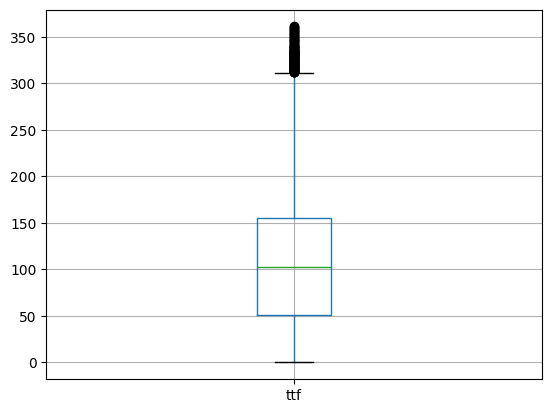

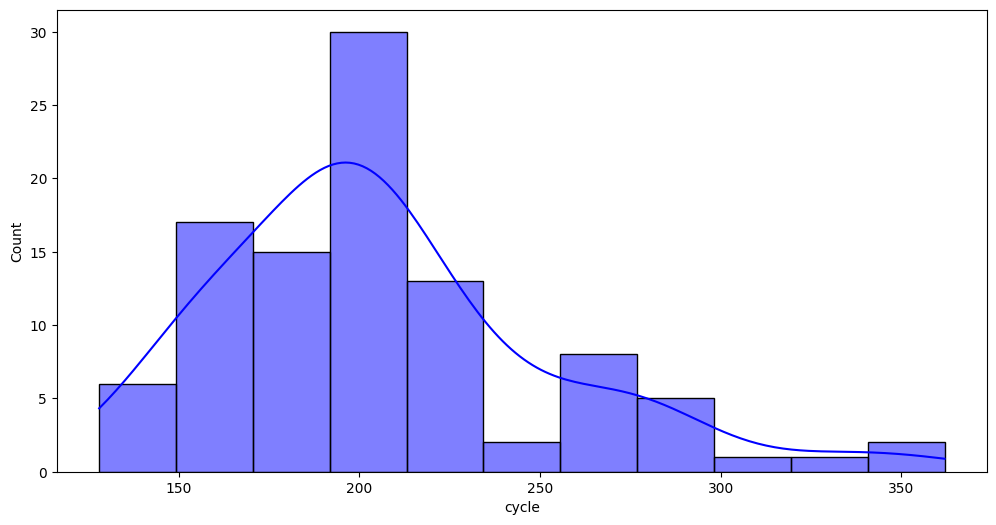

In [ ]:

train[['ttf']].boxplot();

# How is the distribution of last cycle of each engine? Histogram

train_g1 = train.groupby(['id'])[["id" ,"cycle"]].max();

plt.subplots(figsize=(12, 6));
sns.histplot(train_g1["cycle"], kde = True, color='blue');

<Axes: xlabel='cycle', ylabel='ttf'>

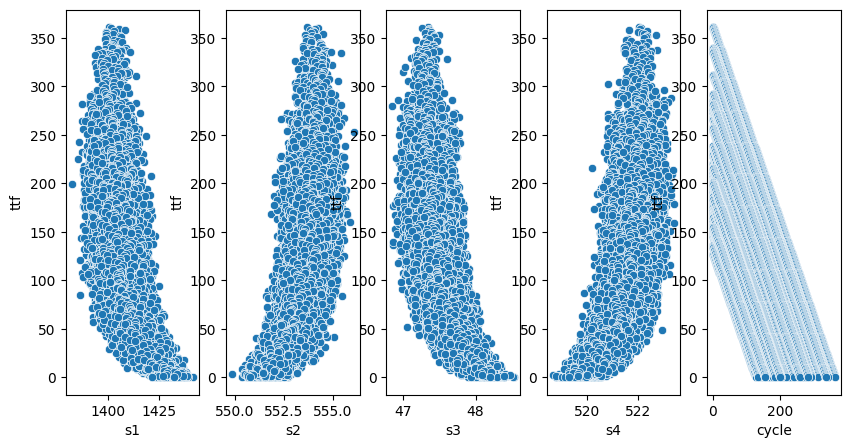

In [ ]:
# Relationship between the independent variables (s1, s2 and s3) and dependent variable (ttf)

fig, (ax1, ax2, ax3,ax4,ax5) = plt.subplots(nrows = 1, ncols = 5, figsize = (10, 5));
sns.scatterplot(x = 's1', y = 'ttf', ax = ax1, data = train) # negative non-linear relationship
sns.scatterplot(x = 's2', y ='ttf', ax = ax2, data = train) # positive non-linear relationship
sns.scatterplot(x = 's3', y = 'ttf', ax = ax3, data = train) # negative non-linear relationship
sns.scatterplot(x = 's4', y = 'ttf', ax = ax4, data = train) # positive non-linear relationship
sns.scatterplot(x = 'cycle', y = 'ttf', ax = ax5, data = train) # negative linear relationship


<Axes: >

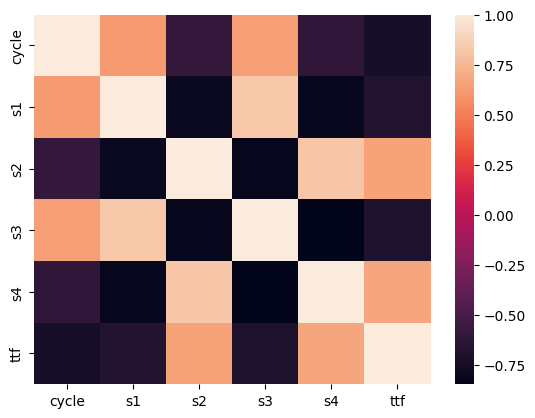

In [ ]:

train.iloc[:,1:7].corr()
sns.heatmap(train.iloc[:,1:7].corr(),
        xticklabels=train.iloc[:,1:7].corr().columns,
        yticklabels=train.iloc[:,1:7].corr().columns)


## Modelling

In [ ]:
independent = ['cycle','s1', 's2', 's3', 's4']
X = train[independent]
y = train.ttf

X_test= test[independent]
y_test=test.ttf

### Regression

#### Elastic Net

In [ ]:
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNetCV
from numpy import arange

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Define model
ratios = arange(0, 1, 0.05)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
elasticnet = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1)

# Fit model
elasticnet.fit(X, y)

print('alpha: %f' % elasticnet.alpha_)
print('l1_ratio_: %f' % elasticnet.l1_ratio_)


alpha: 0.000010
l1_ratio_: 0.000000


In [ ]:
elasticnet.score(X, y)  # Gives the R-square value

y_prediction = elasticnet.predict(X_test)
mse = np.mean((y_prediction - y_test)**2)
print("MSE of test dataset:", mse)


MSE of test dataset: 0.09808930742934013


In [ ]:
coeff = pd.DataFrame()
coeff["Variables"] = X.columns
coeff['Coefficient Estimate'] = pd.Series(elasticnet.coef_)
coeff


,Variables,Coefficient Estimate
0,cycle,0.000385
1,s1,0.007945
2,s2,-0.044765
3,s3,0.340655
4,s4,-0.060991


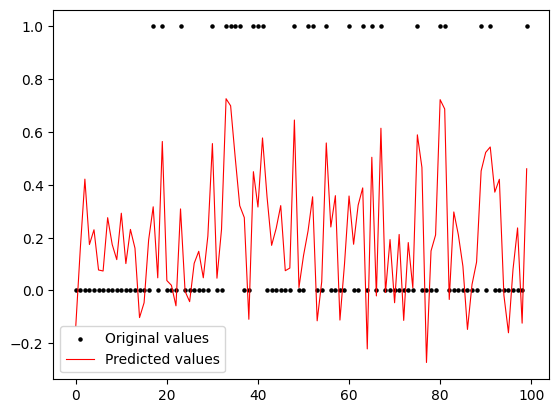

In [ ]:
x_axis = range(len(X_test))
plt.scatter(x_axis, y_test, s=5, color="black", label="Original values")
plt.plot(x_axis, y_prediction, lw=0.8, color="red", label="Predicted values")
plt.legend()
plt.show()


#### Random Forest Model

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)

X_scaled = pd.DataFrame(scaler.transform(X), columns=independent)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=independent)


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=300, max_features="sqrt", n_jobs=-1,
                                 random_state=38, criterion='squared_error')

rf_model.fit(X_scaled, y)
rul_pred = rf_model.predict(X_test_scaled)


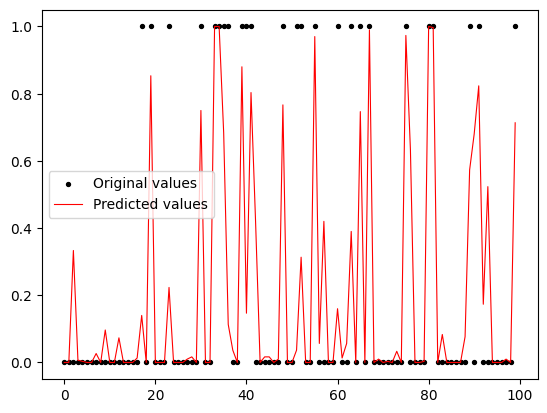

MSE of test dataset: 0.07657677777777777


In [ ]:
# Plot
x_axis = range(len(X_test))
plt.scatter(x_axis, y_test, s=8, color="black", label="Original values")
plt.plot(x_axis, rul_pred, lw=0.8, color="red", label="Predicted values")
plt.legend()
plt.show()

print("MSE of test dataset:", np.mean((rul_pred - y_test)**2))


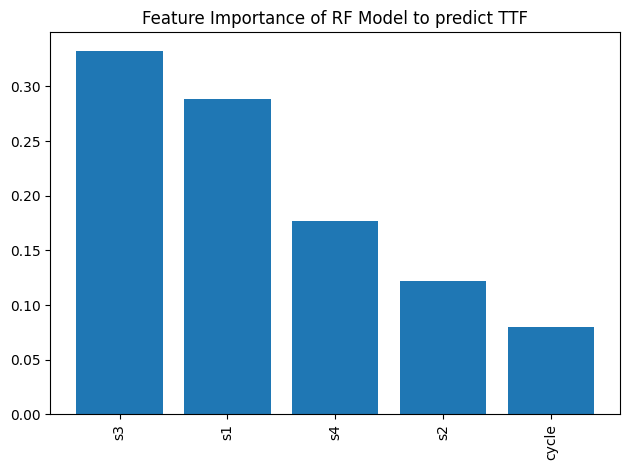

In [ ]:
importance_array = rf_model.feature_importances_
sorted_indices = np.argsort(importance_array)[::-1]
columns = X_scaled.columns[1:]

plt.title('Feature Importance of RF Model to predict TTF')
plt.bar(range(X_scaled.shape[1]), importance_array[sorted_indices], align='center')
plt.xticks(range(X_scaled.shape[1]), X_scaled.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()


## Classification

In [ ]:
# Data Preprocessing
independent = ['cycle', 's1', 's2', 's3', 's4']
X = train[independent]
y = train.label_bnc

X_test = test[independent]
y_test = test.label_bnc

scaler.fit(X)

X_scaled = pd.DataFrame(scaler.transform(X), columns=independent)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=independent)


#### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()

param_grid = {
        'n_neighbors': range(1, 30, 2),
        'weights': ['uniform', 'distance']
}

grid_search = GridSearchCV(estimator=knn,
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           scoring='accuracy')

grid_search.fit(X_scaled, y)

grid_search.best_score_
grid_search.best_params_


{'n_neighbors': 29, 'weights': 'uniform'}

In [ ]:
# Final model
knn_best = KNeighborsClassifier(n_neighbors=29, weights='uniform')
knn_best.fit(X_scaled, y)

# Accuracy score after hyperparameter tuning
knn_best.score(X_test_scaled, y_test)

# Classification report
print(classification_report(y_test, knn_best.predict(X_test_scaled)))


              precision    recall  f1-score   support

           0       0.89      0.96      0.92        75
           1       0.84      0.64      0.73        25

    accuracy                           0.88       100
   macro avg       0.87      0.80      0.83       100
weighted avg       0.88      0.88      0.87       100



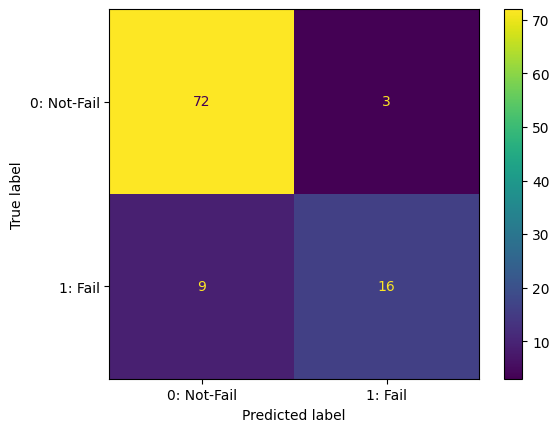

In [ ]:
# Confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, knn_best.predict(X_test_scaled))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['0: Not-Fail', '1: Fail'])
cm_display.plot()
plt.show()
